# Topic modeling

El **Topic Modeling** es una tecnica **no supervisada** NLP, desarrollada para detectar y extraer de manera automatica relaciones semanticas en grandes volumenes de información.

Las relaciones son llamadas **topics**, que basicamente son palabras que suelen aparecer juntas en los mismos contextos y nos permiten establecer de forma automatica relaciones entre distintos documentos.


## LDA o latent Dirichlet Allocation 

Este algoritmo diseñado pro David Blei en 2011, esta diseñado para retornar por un lado los topics y por otro la frecuencia en que dicho topocs aparece en cada documento

Basicamente los topicos son la distribución de probabilidades de las distintas palabras del diccionario

Por ejemplo si estubiesemos interesados en a partir de una cierta fuente de noticias, de identificar documentos que contengan dicha información

Usando LDA, podriamos obtener la siguiente información:

![](https://elmundodelosdatos.com/wp-content/uploads/2021/03/ejmplo-topic-e1616008061311-1024x698.png)

en el ejemplo podemos ver que para el tópico **Violencia de género** una realción de palabras que ordenadas por importancia serian:

| palabra | ratio importancia | % importancia |
|---------|-------------------|---------------|
| Violencia | 0,057 | 5,7% |
| Género | 0,045 | 4,5% |
| Violencia | 0,037 | 3,7% |
| Violencia | 0,036 | 3,6% |

Por otro lado con respecto a la lista de documentos, pordemo ver lo siguiente

| Noticia | probabilidad topico 0 | probabilidad topico 1  | ... |
|---------|-------------------|---------------|---------------|
| Sevilla registra 300 denuncias por violencia de género | **0,4334** | 0,0623 |
| La Xunta revela a los 5 diputados territoriales | 0,0457 | **0,3934** |

## Obtención de datos

Obtenemos los datos desde drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/data/noticias.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')
df.head()

Filas: 5665, Columnas: 2


,titular,texto
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu..."


## Procesamiento y limpieza de datos

In [4]:
import re
# Metodo para limpiar los datos
def limpiar_texto(texto):
  # Eliminación de caracteres especiales (la expresión regular machea contra palabras y la función sub excluye todo los que no coincida)
  texto = re.sub(r'\W', ' ', str(texto))
  # Eliminación de las palabras que tengo un solo caracter
  texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
  # Sustituir la concatenación de espacios en blanco por un solo espacio
  texto = re.sub(r'\s+', ' ', texto, flags=re.I)
  # Converisión del texto en minuscula
  texto = texto.lower()
  return texto

In [5]:
df["Tokens"] = df["texto"].apply(limpiar_texto) # Aplicamos la funcion creada a la columna texto y lo guardamos en una nueva columna Tokens 
df.head()

,titular,texto,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,el virus sars cov 2 entró en españa por la ciu...
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,qué es montai qué relación guarda con las otr...
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,unos 15 robots recorren las calles de medellín...
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...",en una entrevista en radio euskadi recogida po...
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...",españa ha dejado de ser católica decía manuel...


Ahora vamos a tokenizar

In [6]:
from nltk.tokenize import ToktokTokenizer # importamos un tokenizador
tokenizer = ToktokTokenizer() # Lo instanciamos
df["Tokens"] = df.Tokens.apply(tokenizer.tokenize) # Lo aplicamos y sustituimos la columna Tokens, con las listas de Tokens
df.head()

,titular,texto,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[el, virus, sars, cov, 2, entró, en, españa, p..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[qué, es, montai, qué, relación, guarda, con, ..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[unos, 15, robots, recorren, las, calles, de, ..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[en, una, entrevista, en, radio, euskadi, reco..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españa, ha, dejado, de, ser, católica, decía,..."


Ahora quitamos las Stop Words y digitos

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("spanish"))

def eliminar_stopword_y_digitos(tokens):
    """
    Elimina stopwords y digitos de una lista de tokens.
    """
    # Para la lista de tokens filtramos las palabras que no esten definidas como stop words en nltk y que no sean digitos
    return [token for token in tokens if token not in STOPWORDS and not token.isdigit()]

df["Tokens"] = df.Tokens.apply(eliminar_stopword_y_digitos)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,titular,texto,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[virus, sars, cov, entró, españa, ciudad, vito..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[montai, relación, guarda, empresas, quién, de..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[robots, recorren, calles, medellín, realizar,..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[entrevista, radio, euskadi, recogida, europa,..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españa, dejado, ser, católica, decía, manuel,..."


Ahora reducimos todos los tokens a su forma raiz de la palabra

In [8]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

df["Tokens"] = df.Tokens.apply(stem_palabras)

df.head()

,titular,texto,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[virus, sars, cov, entro, españ, ciud, vitori,..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[montai, relacion, guard, empres, quien, detra..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[robots, recorr, call, medellin, realiz, entre..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[entrev, radi, euskadi, recog, europ, press, g..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españ, dej, ser, catol, dec, manuel, azañ, co..."


## Generación de las entradas del modelo LDA

### Diccionario de identificadores y palabras

In [9]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

Ahora vamos a crear un diccionario donde asignamos un identificador único a cada palabra usando la librería Gemsim y nuestro Dataframe

In [10]:
diccionario = Dictionary(df.Tokens)
old_diccionary_len = len(diccionario)
print(f'Número de tokens: {old_diccionary_len}')

Número de tokens: 47388


Ahora reducimos el tamaño de el diccionario, quitando las palabras más raras o demasiado frecuentes. La funcion **filter_extremes**, elimina las palabras que no se encuentren al menos en 2 diccionarios (no_below) y los que estan contenidas en menos del 80% de los documentos (no_above)

In [11]:
diccionario.filter_extremes(no_below=2, no_above = 0.8)
new_diccionary_len = len(diccionario)
print(f'Número de tokens: {new_diccionary_len}')
print(f'Reducido en un : {100-((new_diccionary_len*100)/old_diccionary_len)} %')

Número de tokens: 25522
Reducido en un : 46.142483329112856 %


Ahora generamos el corpus en base al diccionario, donde basicamente para cada ducumento, generamos una **Bolsa de palabras (BOW)**, donde aparece el código de la palabra del diccionario y su frecuencia de aparición

In [12]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in df.Tokens]

# Mostramos el BOW de una noticia
print(corpus[6])

[(3, 1), (25, 1), (26, 6), (29, 1), (40, 1), (41, 3), (44, 1), (48, 7), (52, 2), (67, 1), (68, 1), (77, 1), (86, 1), (94, 1), (96, 1), (108, 4), (116, 1), (118, 1), (121, 1), (131, 2), (146, 2), (149, 2), (164, 1), (172, 1), (176, 2), (178, 1), (193, 1), (204, 1), (210, 1), (222, 1), (235, 3), (236, 4), (238, 1), (245, 1), (268, 1), (276, 1), (283, 1), (295, 1), (299, 1), (311, 3), (312, 2), (339, 1), (349, 1), (367, 11), (372, 1), (394, 12), (407, 1), (413, 1), (431, 1), (436, 2), (439, 1), (440, 1), (450, 1), (454, 2), (462, 2), (475, 3), (478, 2), (492, 1), (498, 1), (502, 2), (513, 2), (525, 1), (531, 3), (549, 1), (561, 1), (574, 1), (587, 2), (615, 1), (631, 1), (640, 1), (650, 3), (653, 2), (656, 1), (660, 1), (677, 1), (680, 1), (683, 1), (684, 1), (686, 2), (694, 1), (732, 1), (784, 2), (793, 2), (794, 1), (804, 2), (817, 3), (830, 1), (839, 1), (840, 1), (842, 1), (852, 1), (866, 2), (913, 1), (915, 1), (917, 2), (921, 2), (933, 1), (958, 1), (1055, 1), (1057, 1), (1060, 1), 

Por ejemplo vemos que la primera tupla es (3,1), lo que significa que la palabra con identificador 3 en el diccionario, aparece 1 vez

In [13]:
diccionario[3]

'afirm'

En este caso la palabra es afirm

# Construcción del modelo LDA

Para crear el modelo LDA, creamos una instancia, y damos valor a los siguientes hiperparametros
- **num_topics:** número de tópicos. Para este tutorial extraeremos 50 tópicos.
- **random_state:** parámetro para controlar la aleatoriedad del proceso de entrenamiento y que nos devuelva siempre los mismos resultados.
- **chunksize:** número de documentos que será utilizado en cada pasada de entrenamiento.
- **passes:** número de pasadas por el corpus durante el entrenamiento.
- **alpha:** representa la densidad de tópicos por documento. Un mayor valor de este parámetro implica que los documentos estén compuestos de más tópicos. En este caso, fijamos el valor en auto.

In [14]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=50, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

Ahora podemos visualizar los topics idemtificados usando **print_topics**, indicando:
- **num_words**: Número de palabras por tópico
- **num_topics**: Número de tópicos a mostrar

In [15]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(32, '0.039*"azul" + 0.036*"luz" + 0.031*"velasc" + 0.029*"sueñ" + 0.021*"eloy"')
(10, '0.025*"respir" + 0.025*"bail" + 0.024*"perr" + 0.021*"jon" + 0.018*"street"')
(34, '0.108*"cantabri" + 0.077*"santand" + 0.044*"cantabr" + 0.025*"miguel" + 0.020*"mar"')
(29, '0.048*"dependent" + 0.026*"punic" + 0.025*"servici" + 0.024*"enfermer" + 0.021*"list"')
(20, '0.057*"israel" + 0.030*"palestin" + 0.020*"brasil" + 0.016*"bolsonar" + 0.015*"trump"')
(38, '0.166*"galici" + 0.092*"galleg" + 0.080*"feijo" + 0.072*"xunt" + 0.033*"nuñez"')
(24, '0.023*"efect" + 0.021*"incendi" + 0.014*"estres" + 0.014*"estudi" + 0.012*"quem"')
(9, '0.036*"miguel" + 0.023*"cas" + 0.015*"conden" + 0.012*"pnv" + 0.011*"corrupcion"')
(3, '0.044*"valencian" + 0.025*"per" + 0.018*"valenci" + 0.016*"cuenc" + 0.015*"valènci"')
(4, '0.035*"cas" + 0.030*"univers" + 0.026*"mast" + 0.019*"cifuent" + 0.014*"curs"')
(26, '0.031*"millon" + 0.023*"eur" + 0.019*"econom" + 0.014*"año" + 0.009*"banc"')
(31, '0.044*"trabaj" + 0.016*"e

Podemos ver algonos tópicos claramente, por ejemplo:
- **topico 49** --> Justicia
- **topico 31** --> Empleo
- **topico 26** --> Economia
- **topico 1** --> Salud
- **topico 3** --> Regiones españa
...


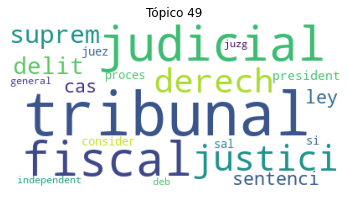

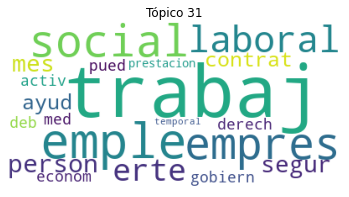

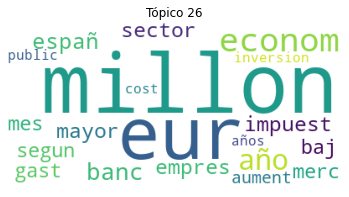

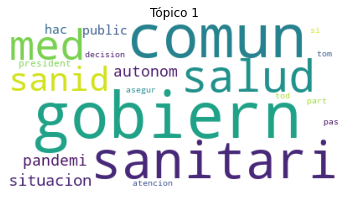

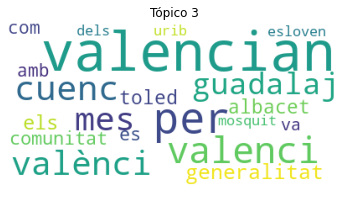

In [17]:
l = [49,31,26,1,3]
for i in l:
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

#Evaluación del Modelo

Para evaluar el modelo en primer lugar elegiremos un aleatoriamiente una noticia, y mostraremos el contenido para comprobar si el modelo ha acertado

In [44]:
def eleccion_aleatoria_articulo(df):
  indice_noticia = random.randint(0,len(df)) # seleccionamos aleatoriamente un indice entre 0 y el número total de noticias
  noticia = df.iloc[indice_noticia] # Obtenemos la noticia
  print("Indice: " + str(indice_noticia)) # Mostramos el indice seleccionado
  print("Titular: " + noticia.titular) # Mostramos el titular
  print("Texto: " +noticia.texto+"\n\n") # Mostramos el contenido
  return indice_noticia # retornamos el indice

In [48]:
def mostrar_resultados_noticia(df, corpus, model):
  %matplotlib inline
  indice_noticia = eleccion_aleatoria_articulo(df) # Selecionamos una noticia al azar a partir de la funcion anterior
  bow_noticia = corpus[indice_noticia] # Extraemos las palabras del diccionario según el indice
  distribucion_noticia = model[bow_noticia] # Pedimos a el modelo, la dristribución de probabilidades por tópicos
  # Indices de los topicos mas significativos
  dist_indices = [topico[0] for topico in distribucion_noticia]
  # % Contribución de los topicos mas significativos
  dist_contrib = [topico[1] for topico in distribucion_noticia]
  # Creamos un dataframe con la distribución de indices y contribuciones
  distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
  # Los ordenamos de mayor a menor importancia
  distribucion_topicos.sort_values('Contribucion', 
                                  ascending=False, inplace=True)
  # Y los pintamos en un histograma, con el 
  ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                    rot=0, color="orange",
                                    title = 'Tópicos mas importantes'
                                    ' de la noticia ' + str(indice_noticia))
  
  for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " *** con probabilidad " + str(topico[1]) )
    palabras = [palabra[0] for palabra in model.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

Indice: 3277
Titular: Los migrantes llegados a Gran Canaria en patera pasan más de 72 horas bajo custodia policial, en el suelo de una nave sucia y sin duchas
Texto: Una nave del Puerto de Las Palmas es la alternativa a las comisarías escogida para la filiación de los migrantes que llegan en patera a Canarias durante la pandemia. El hacinamiento, las malas condiciones de los calabozos y el positivo por COVID-19 registrado en la Comisaría de Maspalomas condujeron a habilitar este espacio como una medida para velar por la salud pública. El 26 de mayo entraron los dos primeros grupos. Ese mismo día, los propios agentes de la Policía Nacional, encargada de custodiar el almacén y de efectuar el registro, procedieron a barrer "el polvo y los restos de cartón y madera" del suelo con "una manguera y escobas", según un oficio emitido por el Jefe Superior de Policía a la Delegación del Gobierno. Desde entonces, los adultos llegados por vía marítima a Gran Canaria han pasado por esa nave, previst

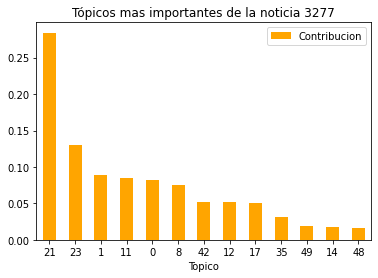

In [51]:
mostrar_resultados_noticia(df, corpus, lda)

Seguramente hemos podido ver que funciona razonablemente bien, pero estamos usando las mismas noticias que hemos usado para entrenar el modelo.

Lo mas interesante seria ver si funciona tambien bien con **noticias nuevas**, y esa es exactamente la prueba que vamos a hacer ahora

In [65]:
# Creamos una función para poder leer la noticia, desde un fichero en drive, indicando el nombre
def leer_noticia_txt(nombre):
  from google.colab import drive
  drive.mount('/content/drive')
  with open(f'/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/data/{nombre}') as f:
    noticia = f.read().replace("\n", " ")
    return noticia

In [98]:
# Leemos la noticia 1, y la msotramos
texto_articulo = leer_noticia_txt('noticia_1.txt')
print('\n\nNoticia: '+ texto_articulo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Noticia: Cantabria vivió en 2019 un "año negro" en lo que se refiere a la violencia de género. En esos doce meses, la comunidad acumuló un total de 2.004 denuncias de mujeres que eran víctimas de violencia machista y el año se saldó con dos de ellas asesinadas a manos de sus parejas, "unas cifras que sobrecogen, pero que también marcan la hoja de ruta", según ha reconocido este viernes el portavoz del Gobierno autonómico, Pablo Zuloaga, durante la presentación de la memoria anual.  Y es que los malos datos no paran ahí. Este informe recoge que el número de denuncias presentadas en Cantabria el año pasado supone la cifra más alta registrada hasta ahora, o que se dictaron un total de 116 órdenes de alejamiento y que el 86% de los acusados fueron condenados en firme por los tribunales, unos registros que "avergüenzan" a la sociedad, ha expresado el vicepreside

Vamos a crear una función que a partir de un texto, use el modelo entrenado, y nos retorne el topico al que pertenece el texto

In [103]:
def obtener_topicos_para_un_texto(texto, modelo):
  # Lo primero realizamos las tareas de limpieza sobre el texto
  articulo_nuevo = limpiar_texto(texto) # Llamamos a la funcion que creamos antes para limpiar el texto
  articulo_nuevo = tokenizer.tokenize(articulo_nuevo) # Usamos el tokenizador para tokenizar
  articulo_nuevo = eliminar_stopword_y_digitos(articulo_nuevo) # Eliminamos digitos y Stop Words del texto
  articulo_nuevo = stem_palabras(articulo_nuevo) # Dejamos solo la raiz de las palabras
  # Ahora generamos el diccionario de bolsa de palabras
  bow_articulo_nuevo = diccionario.doc2bow(articulo_nuevo)
  dist_indices = [topico[0] for topico in modelo[bow_articulo_nuevo]] # Indices de los topicos mas significativos
  dist_contrib = [topico[1] for topico in modelo[bow_articulo_nuevo]] # Contribucion de los topicos mas significativos
  distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib }) # Generamos un dataframe con Topicos y contribuciones antes calculados
  distribucion_topicos.sort_values('Contribucion', 
                                  ascending=False, inplace=True) # Los ordenamos de mayor a menor contribución
  ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                    rot=0, color="green",
                                    title = 'Tópicos más importantes' 
                                    'para documento nuevo') # Pintamos el gráfico
  for ind, topico in distribucion_topicos.iterrows(): # Iteramos por la distribución de topicos y pintamos los mas significativos
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

Obtenemos la bolsa de palabras

*** Tópico: 7 ***
mujer, sexual, violenci, gener, hombr, muj, person, femin, victim, iguald 

*** Tópico: 1 ***
gobiern, comun, sanitari, salud, med, sanid, situacion, autonom, pandemi, public 

*** Tópico: 0 ***
cas, resident, posit, person, centr, fallec, dat, ultim, cov, coronavirus 

*** Tópico: 49 ***
tribunal, judicial, fiscal, justici, derech, suprem, delit, sentenci, ley, cas 

*** Tópico: 11 ***
años, cas, pas, dos, hac, dia, llev, sal, trabaj, lleg 

*** Tópico: 35 ***
proyect, agu, desarroll, medi, cambi, form, zon, climat, ciud, ecolog 

*** Tópico: 34 ***
cantabri, santand, cantabr, miguel, mar, salmeron, torrelaveg, ceip, menendez, altamir 

*** Tópico: 18 ***
contrat, eur, empres, montai, adjud, grup, concurs, public, trabaj, factur 

*** Tópico: 46 ***
histori, libr, pelicul, cin, años, vid, mund, personaj, obra, autor 

*** Tópico: 43 ***
pp, gobiern, part, polit, ciudadan, pod, sanchez, pso, cas, president 

*** Tópico: 23 ***
canari, navarr, barcelon, foral, palm, ap

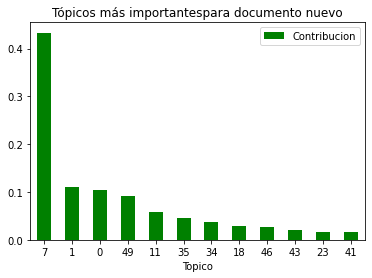

In [104]:
obtener_topicos_para_un_texto(texto_articulo, lda)

Ahora provamos con otro texto...

In [105]:
texto_articulo_2 = leer_noticia_txt('noticia_2.txt')
print('\n\nNoticia: '+ texto_articulo_2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Noticia: El Servicio Postal de Estados Unidos (USPS, por sus siglas en inglés) se ha convertido en los últimos días en protagonista de la pelea entre Donald Trump y los demócratas de cara a las elecciones del próximo 3 de noviembre.  El presidente clama contra "los riesgos de fraude del voto universal por correo" y dice que, si se permite, Estados Unidos será "el hazmerreír de todo el mundo".  Del otro lado, los demócratas, liderados por la presidenta de la Cámara de Representantes, Nancy Pelosi, denuncian que Trump encabeza "una campaña para sabotear las elecciones".  Este año, además, el país se encuentra en plena pandemia de coronavirus, lo que desanimará aún más a los electores a acudir a las urnas.  Se espera, por tanto, que el voto por correo alcance cifras récord y de ahí que haya cobrado especial relevancia en el debate político.  El propio servicio

*** Tópico: 30 ***
vot, eleccion, part, electoral, candidat, pod, alcald, campañ, result, ayunt 

*** Tópico: 19 ***
hac, si, pued, cre, ser, pod, sol, habl, cos, pas 

*** Tópico: 39 ***
pais, unid, president, efe, internacional, polit, trump, pas, gobiern, dij 

*** Tópico: 1 ***
gobiern, comun, sanitari, salud, med, sanid, situacion, autonom, pandemi, public 

*** Tópico: 2 ***
the, festival, york, of, nuev, and, to, in, on, is 

*** Tópico: 17 ***
inform, public, guardi, civil, empres, movil, dat, segur, marz, servici 

*** Tópico: 43 ***
pp, gobiern, part, polit, ciudadan, pod, sanchez, pso, cas, president 

*** Tópico: 46 ***
histori, libr, pelicul, cin, años, vid, mund, personaj, obra, autor 

*** Tópico: 49 ***
tribunal, judicial, fiscal, justici, derech, suprem, delit, sentenci, ley, cas 



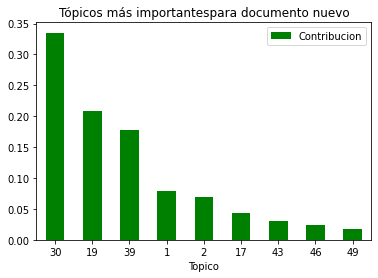

In [108]:
obtener_topicos_para_un_texto(texto_articulo_2, lda)

Parece que el modelo esta funcionando correctamente en el contexto de clasificar el texto por topics